<h2 align="center">
	Unitary Preparation of Tensor Network States
</h2>

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pickle as pkl

import sys
from os.path import dirname, abspath
sys.path.append('/home/mohsin/Documents/gh/gh_qsp/scr')

import quimb.tensor as qtn

from tsp_misc_tns import make_aklt_mps, make_splitted_mps
from tsp_misc_tns import make_aklt_peps

from tsp import MPSPreparation, PEPSPreparation

2023-08-29 17:43:50.085407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 17:43:51.705528: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-29 17:43:51.705656: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-29 17:43:55.420319: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Given the requirements load/construct MPS of cetain length.

In [5]:
mps_type = 'aklt'#'heisenberg'#'heisenberg'#'random'#

if mps_type == 'aklt':
    tens, bond = make_aklt_mps(L=6)
    tens = make_splitted_mps(tens)
    target_mps = qtn.MatrixProductState(tens, shape='lrp')
    target_mps.normalize()
    
    
if mps_type == 'random':
    target_mps = qtn.MPS_rand_state(L=12, bond_dim=4)
    target_mps.permute_arrays(shape='lrp')
    
    
if mps_type in ['P4','N2','heisenberg']:
    filenames = {'P4': 'data/P4_6-31G_dist2.0000.pkl', 
                'N2': 'data/N2_STO-6G_dist2.0000.pkl',
                'heisenberg':'data/heisenberg_L32_dist0.8000.pkl'}
    
    with open(filenames[mps_type], 'rb') as f:
        data = pkl.load(f)
    
    target_mps = data['quimb_mps']
    target_mps.permute_arrays(shape='lpr')



<h2 align="center">
	Matrix Product States
</h2>
<h3 align="left">
	1. Sequential preparation
</h3>


$$
| \psi[A] \rangle \approx  (U_0. U_1. … U_D) |00...0\rangle
$$


where $D$ is the number of layers of unitaries $U_i$ (see [[1]], [[2]]).
 

[1]: https://arxiv.org/pdf/2209.07106.pdf
[2]: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.101.032310

In [6]:
prep = MPSPreparation(target_mps)
number_of_layers = 6
prep.seq_preparation(number_of_layers, do_compression=False)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


overlap to target mps from constructed circuit = 0.9315328994866521
overlap from static seq. preparation = 0.93153290, n_gates=528, n_2qg=172


In [8]:
circ = prep.seq_data['circ']
circ.size()

528

<h3 align="left">
	2. Variational optimization over sequentially prepared unitaries
</h3>

In [9]:
prep = MPSPreparation(target_mps)
number_of_layers = 2
n_iter, nhop = 40, 4
prep.variational_seq_preparation(number_of_layers, do_compression=False, n_iter=n_iter, nhop=nhop, verbose=False)

100%|██████████| 2/2 [00:00<00:00,  5.22it/s]


overlap to target mps from constructed circuit = 0.8442918481555088
overlap from static seq. preparation = 0.84429185, n_gates=162, n_2qg=50

now doing variational optimization over gates


/home/mohsin/programs/miniconda3/envs/spy/lib/python3.10/site-packages/quimb/tensor/circuit.py:1203: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(
2023-08-29 17:48:40.414769: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-08-29 17:48:40.414859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: p52s
2023-08-29 17:48:40.414870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: p52s
2023-08-29 17:48:40.417700: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.86.5
2023-08-29 17:48:40.417766: I tensorflow/compiler/xla/st


overlap to target mps from constructed circuit =  0.8442918149117014
overllap after variational optimization = -inf,  n_gates=162, n_2qg=50


<h3 align="left">
	3. Quantum Circuit Tensor Network Ansatz
</h3>

In [28]:
prep = MPSPreparation(target_mps)
depth = 8
n_iter, nhop = 40, 4,
prep.qctn_preparation(depth, n_iter=n_iter, nhop=nhop)

number of gates in the circuit (from QCTN) are 196


2023-08-28 23:30:58.312518: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


overlap before optimization = -0.0062975846



-0.990385949612 [best: -0.990385949612] : : 219it [09:09,  2.51s/it]                       



overlap to target mps from constructed circuit =  0.9903873693512378
overllap after qctn optimization = 0.99038595,  n_gates=196, n_2qg=88


<h3 align="left">
	4. Preparation using Linear Combinition of unitaries (LCU)
</h3>

\begin{aligned}
	|\psi[A] \rangle = \left( U_0 + \kappa_1U_1 + \kappa_2U_2 + \dots\right)|00\dots0\rangle,
\end{aligned}

see [[1]] for details

[1]: https://arxiv.org/pdf/2209.07106.pdf


In [29]:
prep = MPSPreparation(target_mps)
number_of_lcu_layers = 4
prep.lcu_preparation(number_of_lcu_layers, verbose=False)

100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


[0.7334948594809657, (0.8775092331592993+0j)]
overllap after lcu. preparation = 0.87750923,  n_gates=3045, n_2qg=1266


<h3 align="left">
	5. Variational optimization over LCU construction
</h3>

In [35]:
prep = MPSPreparation(target_mps)
number_of_lcu_layers = 4
prep.variational_lcu_preparation(number_of_lcu_layers, verbose=True)

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         -8.7750923315929907e-01    9.14495638e-02    
   2         -8.9352401031818407e-01    4.54202901e-02    
   3         -9.0148262335783946e-01    2.97225155e-02    
   4         -9.0711207862857834e-01    3.08001618e-02    
   5         -9.1052130792099861e-01    1.97377157e-02    
   6         -9.1224506959646257e-01    1.68739312e-02    
Terminated - max time reached after 6 iterations.

overllap after lcu optimization (manopt) = 0.91224507



<h3 align="left">
	6. Adiabatic state Preparation of MPS
</h3>

adiabatic state preparation of mps:
runtime=6, tau=0.04, steps=150, max_bond=2



  0%|          | 0/151 [00:00<?, ?it/s]/home/mohsin/programs/miniconda3/envs/spy/lib/python3.10/site-packages/quimb/utils.py:167: Warning: The tensor_core.get_symbol function is deprecated in favor of contraction.get_symbol
  warnings.warn(f"The {old_name} function is deprecated in favor "
100%|██████████| 151/151 [00:54<00:00,  2.77it/s]

final overlap @ s=1.00000 is e=0.00322278, curr_f=0.99799178, and target_fid=0.99799178



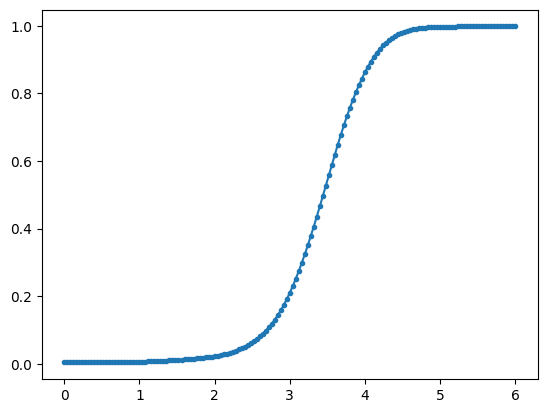

In [36]:
L = 8
tensor_array, _ = make_aklt_mps(L)
target_mps = qtn.MatrixProductState(tensor_array, shape='lrp')
prep = MPSPreparation(target_mps)

Tmax, tau = 6, 0.04 #total runtime, trotter step size
max_bond = 2
prep.adiabatic_state_preparation(Tmax, tau, max_bond, verbose=False)

plt.plot(mps_p.adiabatic_data['target_fidelity'].keys(), mps_p.adiabatic_data['target_fidelity'].values(), '.-')

<h2 align="center">
	Projected Entangled Pair States (PEPS) in 2d
</h2>
<h3 align="left">
	1. Adiabatic state Preparation
</h3>

100%|██████████| 251/251 [1:38:12<00:00, 23.48s/it]


2d adiabatic preparation: @ s=1.00000, e=0.00506879 and f=0.99098100



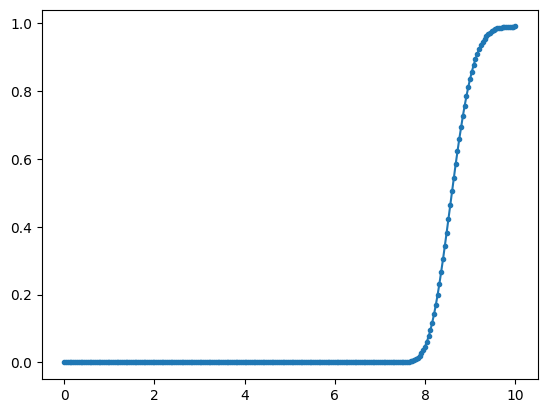

In [4]:
Lx, Ly = 10, 4
target_grid, _ = make_aklt_peps(Lx, Ly)
prep = PEPSPreparation(target_grid)

Tmax, tau = 10, 0.04
max_bond = 2
prep.adiabatic_state_preparation(Tmax, tau, max_bond, verbose=False)

plt.plot(prep.adiabatic_data['target_fidelity'].keys(), prep.adiabatic_data['target_fidelity'].values(), '.-')
